In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
with open('../mfcc_loader/mfcc_dict.pickle', 'rb') as handle: 
        mfcc_dict = pickle.load(handle)

        
plt.pcolormesh(mfcc_dict[0][0])
plt.show()
plt.pcolormesh(mfcc_dict[0][1])
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [2]:
# """data preprocessing"""
# X = []
# y = []
# for it_0 in range(len(mfcc_dict)):
#     X_column = []
#     y_column = []
#     for it_1 in range(len(mfcc_dict[0])):
#         tmp = np.array(mfcc_dict[it_0][it_1])
#         tmp.resize((50, 13))
#         X_column.append(tmp)
#         y_column.append(it_1)
#     X.append(X_column)
#     y.append(y_column)
# X = np.array(X)
# y = np.array(y)

53.1
9.004998611882181
5


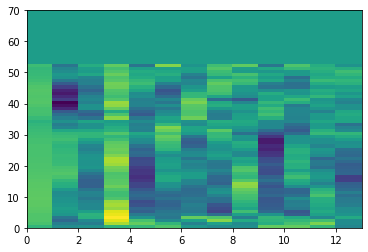

(22, 10, 70, 13)


In [3]:
"""data preprocessing"""
X = []
y = []
to_avg = []
for it_0 in range(len(mfcc_dict)):
    X_column = []
    y_column = []
    for it_1 in range(len(mfcc_dict[0])):
        tmp = np.array(mfcc_dict[it_0][it_1])
        to_avg.append(tmp.shape[0])
        if tmp.shape[0] > 70:
            tmp = tmp[:70, :]
        else:
            to_append = np.zeros((70 - tmp.shape[0], 13))
            tmp = np.concatenate((tmp, to_append), axis=0)
        X_column.append(tmp)
        y_column.append(it_1)
    X.append(X_column)
    y.append(y_column)
    
X = np.array(X)
y = np.array(y)
print(np.mean(to_avg))
print(np.std(to_avg))
print(y[10, 5])
plt.pcolormesh(X[10, 5])
plt.show()
print(X.shape)

In [4]:
# plt.pcolormesh(X[21, 5])
# print(y[21][5])

In [22]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.constraints import unit_norm
from keras.optimizers import Adam

input_shape = 70*13
print(input_shape)

"""MultiLayer Perceprton implementation"""

model_dense_input = Input(shape=(input_shape,))
model_dense = Dense(units=128, activation='relu', input_dim=input_shape,
             kernel_constraint=unit_norm())(model_dense_input)
model_dense = Dropout(0.5)(model_dense)
model_dense = Dense(units=128, activation='relu')(model_dense)
model_dense = Dense(units=64, activation='relu')(model_dense)
model_dense = Dense(units=10, activation='softmax')(model_dense)
model_dense = Model(inputs=model_dense_input, output=model_dense)

model_dense.summary()

adam = Adam(lr = 0.001)
model_dense.compile(loss='categorical_crossentropy',
             optimizer = adam, metrics=['accuracy'])
model_dense.save('model_dense_untrained.h5')

910


c:\users\wiktor\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 910)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               116608    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_20 (Dense)             (None, 10)                650       
Total params: 142,026
Trainable params: 142,026
Non-trainable params: 0
_____________________________________________________

In [23]:
from sklearn.model_selection import KFold
from keras.models import load_model
from keras.utils import to_categorical
from tqdm import tqdm
x_valid = KFold(n_splits=5)
acc_vector = []
for train_idxs, test_idxs in tqdm(x_valid.split(X)):
    """loading untrained model"""
    model = load_model('model_dense_untrained.h5')
    """importing data"""
    X_train = X[train_idxs, :]
    X_test = X[test_idxs, :]
    y_train = y[train_idxs, :]
    y_test = y[test_idxs, :]
    """reshaping to 2d tensor 
        axis0 - n0 of data example
        axis1 - mfcc flatten to feed into FNN"""
    X_train_flat = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], 70*13))
    y_train = np.reshape(y_train, (y_train.shape[0]*y_train.shape[1]))
    y_train_onehot = to_categorical(y_train, 10)
    X_test_flat = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], 70*13))
    y_test = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1]))    
    y_test_onehot = to_categorical(y_test, 10)
    
    model.fit(X_train_flat, y_train_onehot, epochs=20, steps_per_epoch=1, 
          validation_data=(X_test_flat, y_test_onehot), validation_steps=100)
    score, acc = model.evaluate(X_test_flat, y_test_onehot, batch_size=10)
    acc_vector.append(acc)


0it [00:00, ?it/s]

Train on 170 samples, validate on 50 samples
Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 11.0192 - acc: 0.1412 - val_loss: 3.9359 - val_acc: 0.6000
Epoch 2/20
1/1 [==============================] - 0s 391ms/step - loss: 7.1576 - acc: 0.3412 - val_loss: 1.9367 - val_acc: 0.7000
Epoch 3/20
1/1 [==============================] - 0s 351ms/step - loss: 4.1906 - acc: 0.5471 - val_loss: 1.4608 - val_acc: 0.9000
Epoch 4/20
1/1 [==============================] - 0s 346ms/step - loss: 2.4268 - acc: 0.6941 - val_loss: 1.1186 - val_acc: 0.9000
Epoch 5/20
1/1 [==============================] - 0s 337ms/step - loss: 1.6389 - acc: 0.7941 - val_loss: 0.7432 - val_acc: 0.9000
Epoch 6/20
1/1 [==============================] - 0s 356ms/step - loss: 1.9018 - acc: 0.7706 - val_loss: 0.3540 - val_acc: 0.9000
Epoch 7/20
1/1 [==============================] - 0s 348ms/step - loss: 1.3132 - acc: 0.8529 - val_loss: 0.0251 - val_acc: 1.0000
Epoch 8/20
1/1 [==============================]


1it [00:12, 12.48s/it]

Train on 170 samples, validate on 50 samples
Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 11.3529 - acc: 0.1235 - val_loss: 3.6121 - val_acc: 0.6000
Epoch 2/20
1/1 [==============================] - 0s 336ms/step - loss: 6.9307 - acc: 0.3353 - val_loss: 1.8475 - val_acc: 0.8000
Epoch 3/20
1/1 [==============================] - 0s 341ms/step - loss: 3.6947 - acc: 0.5706 - val_loss: 1.6139 - val_acc: 0.9000
Epoch 4/20
1/1 [==============================] - 0s 370ms/step - loss: 2.7036 - acc: 0.6353 - val_loss: 1.6123 - val_acc: 0.9000
Epoch 5/20
1/1 [==============================] - 0s 352ms/step - loss: 1.8543 - acc: 0.8118 - val_loss: 1.6124 - val_acc: 0.9000
Epoch 6/20
1/1 [==============================] - 0s 335ms/step - loss: 1.8204 - acc: 0.8059 - val_loss: 1.3498 - val_acc: 0.9000
Epoch 7/20
1/1 [==============================] - 0s 337ms/step - loss: 1.7867 - acc: 0.8353 - val_loss: 1.1540 - val_acc: 0.9000
Epoch 8/20
1/1 [==============================]


2it [00:25, 12.50s/it]

Train on 180 samples, validate on 40 samples
Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 10.9826 - acc: 0.1778 - val_loss: 3.4737 - val_acc: 0.6000
Epoch 2/20
1/1 [==============================] - 0s 328ms/step - loss: 6.4887 - acc: 0.3722 - val_loss: 1.8713 - val_acc: 0.8000
Epoch 3/20
1/1 [==============================] - 0s 336ms/step - loss: 3.9865 - acc: 0.5667 - val_loss: 1.6135 - val_acc: 0.9000
Epoch 4/20
1/1 [==============================] - 0s 321ms/step - loss: 2.5682 - acc: 0.7167 - val_loss: 1.4802 - val_acc: 0.9000
Epoch 5/20
1/1 [==============================] - 0s 314ms/step - loss: 2.3810 - acc: 0.7389 - val_loss: 0.9881 - val_acc: 0.9000
Epoch 6/20
1/1 [==============================] - 0s 329ms/step - loss: 1.5477 - acc: 0.8222 - val_loss: 0.2288 - val_acc: 0.9000
Epoch 7/20
1/1 [==============================] - 0s 325ms/step - loss: 1.1392 - acc: 0.8389 - val_loss: 0.0118 - val_acc: 1.0000
Epoch 8/20
1/1 [==============================]


3it [00:37, 12.42s/it]

Train on 180 samples, validate on 40 samples
Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 11.3822 - acc: 0.1389 - val_loss: 3.7089 - val_acc: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 325ms/step - loss: 7.3026 - acc: 0.3278 - val_loss: 2.1099 - val_acc: 0.7000
Epoch 3/20
1/1 [==============================] - 0s 315ms/step - loss: 4.5662 - acc: 0.5500 - val_loss: 1.6525 - val_acc: 0.9000
Epoch 4/20
1/1 [==============================] - 0s 343ms/step - loss: 3.3796 - acc: 0.5833 - val_loss: 1.6124 - val_acc: 0.9000
Epoch 5/20
1/1 [==============================] - 0s 338ms/step - loss: 2.1065 - acc: 0.8056 - val_loss: 1.6124 - val_acc: 0.9000
Epoch 6/20
1/1 [==============================] - 0s 324ms/step - loss: 1.8460 - acc: 0.8556 - val_loss: 1.6121 - val_acc: 0.9000
Epoch 7/20
1/1 [==============================] - 0s 342ms/step - loss: 1.8489 - acc: 0.8500 - val_loss: 1.6119 - val_acc: 0.9000
Epoch 8/20
1/1 [==============================]


4it [00:49, 12.49s/it]

Train on 180 samples, validate on 40 samples
Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 10.9387 - acc: 0.1722 - val_loss: 4.1884 - val_acc: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 367ms/step - loss: 7.1497 - acc: 0.3278 - val_loss: 2.7617 - val_acc: 0.7000
Epoch 3/20
1/1 [==============================] - 0s 345ms/step - loss: 4.5759 - acc: 0.5667 - val_loss: 2.0236 - val_acc: 0.8000
Epoch 4/20
1/1 [==============================] - 0s 337ms/step - loss: 3.0225 - acc: 0.6944 - val_loss: 1.2695 - val_acc: 0.9000
Epoch 5/20
1/1 [==============================] - 0s 341ms/step - loss: 2.2198 - acc: 0.7556 - val_loss: 0.6458 - val_acc: 0.9000
Epoch 6/20
1/1 [==============================] - 0s 344ms/step - loss: 1.5278 - acc: 0.7889 - val_loss: 0.1273 - val_acc: 0.9000
Epoch 7/20
1/1 [==============================] - 0s 327ms/step - loss: 0.8839 - acc: 0.8667 - val_loss: 5.1631e-04 - val_acc: 1.0000
Epoch 8/20
1/1 [===========================


5it [01:02, 12.58s/it]

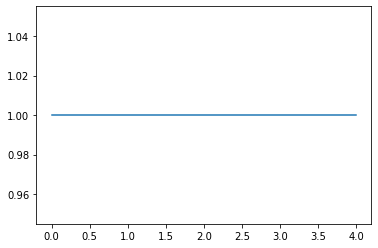

In [25]:
plt.plot(acc_vector)
#plt.ylim(0,1)